In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams.update({
    "figure.figsize": (8, 5),
    "font.size": 10,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False
})

COLORS = {
    "eng": "#2E86AB",
    "swa": "#A23B72",
    "amh": "#F18F01"
}


In [ ]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 10

SUBTASK_NAMES = {
    1: 'Binary Polarization Detection',
    2: 'Multi-Label Polarization Classification',
    3: 'Manifestation Identification'
}

OUTPUT_DIR = "results/figures/"

def load_data(csv_path='./prediction_score.csv'):
    """Load and validate data"""
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} results")
        return df
    except FileNotFoundError:
        print("Error: prediction_score.csv not found.")
        return pd.DataFrame()

def get_color_mapping(df):
    """Dynamically assign a consistent color to each language found in the CSV"""
    languages = sorted(df['language'].unique())
    # Use a high-contrast palette
    palette = sns.color_palette("husl", len(languages))
    return dict(zip(languages, palette))

def create_output_dir():
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created output directory: {OUTPUT_DIR}")

def plot_subtask_overview(df, subtask, color_map):
    """
    Restores your exact 4-panel layout: 
    1. Bar Chart | 2. Avg Lang Performance
    3. Scatter   | 4. Ranking Table
    """
    subtask_df = df[df['subtask'] == subtask].copy()
    
    if len(subtask_df) == 0:
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f'Subtask {subtask}: {SUBTASK_NAMES.get(subtask, "Unknown")}', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Layout: 2x2 grid
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    
    languages = sorted(subtask_df['language'].unique())
    models = sorted(subtask_df['model'].unique())
    
    x = np.arange(len(models))
    width = 0.8 / len(languages)
    
    for i, lang in enumerate(languages):
        lang_data = subtask_df[subtask_df['language'] == lang]
        scores = [lang_data[lang_data['model'] == m]['f1_macro'].values[0] 
                 if len(lang_data[lang_data['model'] == m]) > 0 else 0 
                 for m in models]
        
        offset = width * (i - len(languages)/2 + 0.5)
        # FIX: Use dynamic color_map
        bars = ax1.bar(x + offset, scores, width, label=lang.upper(), 
                      color=color_map[lang], alpha=0.85, edgecolor='white')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.2f}', ha='center', va='bottom', 
                        fontsize=7, rotation=90)
    
    ax1.set_xlabel('Model', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Macro F1 Score', fontsize=11, fontweight='bold')
    ax1.set_title('Model Performance by Language', fontsize=12, fontweight='bold', pad=10)
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.split('-')[0] for m in models], rotation=45, ha='right', fontsize=9)
    ax1.legend(loc='upper right', framealpha=0.9, fontsize=8)
    ax1.set_ylim([0, 1.1]) # Little extra room for labels
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    ax2 = fig.add_subplot(gs[0, 1])
    
    lang_avg = subtask_df.groupby('language')['f1_macro'].agg(['mean', 'std', 'max']).reset_index()
    
    # FIX: Use dynamic color_map
    bars = ax2.bar(range(len(lang_avg)), lang_avg['mean'], 
                  color=[color_map[l] for l in lang_avg['language']],
                  alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax2.errorbar(range(len(lang_avg)), lang_avg['mean'], yerr=lang_avg['std'],
                fmt='none', ecolor='black', capsize=5, capthick=2)
    
    for i, (bar, row) in enumerate(zip(bars, lang_avg.itertuples())):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')

    ax2.set_xlabel('Language', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Macro F1 Score', fontsize=11, fontweight='bold')
    ax2.set_title('Average Performance by Language', fontsize=12, fontweight='bold', pad=10)
    ax2.set_xticks(range(len(lang_avg)))
    ax2.set_xticklabels(lang_avg['language'].str.upper(), fontsize=10)
    ax2.set_ylim([0, 1.1])
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    ax3 = fig.add_subplot(gs[1, 0])
    
    for lang in languages:
        lang_data = subtask_df[subtask_df['language'] == lang]
        # FIX: Use dynamic color_map
        ax3.scatter(lang_data['f1_macro'], lang_data['f1_micro'], 
                   s=150, alpha=0.7, color=color_map[lang],
                   label=lang.upper(), edgecolors='black', linewidth=1.5)
    
    lims = [0, 1]
    ax3.plot(lims, lims, 'k--', alpha=0.3, linewidth=2, label='Macro = Micro')
    ax3.set_xlabel('Macro F1', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Micro F1', fontsize=11, fontweight='bold')
    ax3.set_title('Macro vs Micro F1 Score', fontsize=12, fontweight='bold', pad=10)
    ax3.legend(loc='lower right', framealpha=0.9, fontsize=8)
    ax3.set_xlim([0, 1])
    ax3.set_ylim([0, 1])
    ax3.grid(alpha=0.3, linestyle='--')

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    
    ranking = subtask_df.sort_values('f1_macro', ascending=False).copy()
    ranking['rank'] = range(1, len(ranking) + 1)
    
    table_data = []
    for _, row in ranking.head(10).iterrows():
        table_data.append([
            f"{row['rank']}",
            row['model'].split('-')[0][:12],
            row['language'].upper(),
            f"{row['f1_macro']:.4f}",
            f"{row['f1_micro']:.4f}"
        ])
    
    if table_data:
        table = ax4.table(cellText=table_data,
                        colLabels=['Rank', 'Model', 'Lang', 'Macro F1', 'Micro F1'],
                        cellLoc='center', loc='center',
                        colWidths=[0.1, 0.35, 0.15, 0.2, 0.2])
        
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.8)
        
        for i in range(5):
            table[(0, i)].set_facecolor('#34495E')
            table[(0, i)].set_text_props(weight='bold', color='white')

    filename = f"{OUTPUT_DIR}/Subtask_{subtask}_Overview.pdf"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"Saved: {filename}")
    plt.close()

def plot_heatmap_comparison(df):
    """
    Generates and saves a SEPARATE heatmap PDF for each subtask.
    """
    subtasks = sorted(df['subtask'].unique())
    
    for subtask in subtasks:
        subtask_df = df[df['subtask'] == subtask].copy()
        
        if len(subtask_df) == 0:
            continue
            
        plt.figure(figsize=(10, 8))
        
        pivot = subtask_df.pivot_table(
            values='f1_macro', index='model', columns='language', aggfunc='first'
        )
        
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                   vmin=0, vmax=1, cbar=True,
                   linewidths=1, linecolor='white',
                   annot_kws={'fontsize': 10, 'fontweight': 'bold'})
        
        plt.title(f'Subtask {subtask}: {SUBTASK_NAMES.get(subtask, "Unknown")}\nHeatmap Analysis', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Language', fontsize=12, fontweight='bold')
        plt.ylabel('Model', fontsize=12, fontweight='bold')
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        
        # Save individually
        filename = f"{OUTPUT_DIR}/Heatmap_Subtask_{subtask}.pdf"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        print(f"Saved: {filename}")
        plt.close()

def plot_model_specialization(df, color_map):
    """Restores your specialization layout: Best models bar chart + Win count"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Model Specialization Analysis', fontsize=16, fontweight='bold')
    
    # Left: Best model per subtask-language
    ax1 = axes[0]
    
    combinations = []
    best_models = []
    scores = []
    
    for subtask in sorted(df['subtask'].unique()):
        for lang in sorted(df['language'].unique()):
            subset = df[(df['subtask'] == subtask) & (df['language'] == lang)]
            if len(subset) > 0:
                best = subset.loc[subset['f1_macro'].idxmax()]
                combinations.append(f"S{subtask}-{lang.upper()}")
                best_models.append(best['model'].split('-')[0][:12])
                scores.append(best['f1_macro'])
    
    y_pos = np.arange(len(combinations))
    
    # Color bars by model name uniquely
    unique_models = list(set(best_models))
    model_palette = sns.color_palette("Set2", len(unique_models))
    model_color_map = dict(zip(unique_models, model_palette))
    bar_colors = [model_color_map[m] for m in best_models]
    
    bars = ax1.barh(y_pos, scores, color=bar_colors, alpha=0.85, edgecolor='black')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(combinations, fontsize=9)
    ax1.set_xlabel('Macro F1 Score')
    ax1.set_title('Best Model per Context', fontsize=12, fontweight='bold')
    
    for bar, model, score in zip(bars, best_models, scores):
        width = bar.get_width()
        ax1.text(width - 0.02, bar.get_y() + bar.get_height()/2,
                f'{model} ({score:.2f})', ha='right', va='center',
                fontsize=8, fontweight='bold', color='white',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.4))

    # Right: Win counts
    ax2 = axes[1]
    model_wins = pd.Series(best_models).value_counts()
    
    ax2.bar(range(len(model_wins)), model_wins.values, 
            color=[model_color_map[m] for m in model_wins.index],
            edgecolor='black')
    ax2.set_xticks(range(len(model_wins)))
    ax2.set_xticklabels(model_wins.index, rotation=45, ha='right')
    ax2.set_title('Total Wins by Model', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    filename = f"{OUTPUT_DIR}/Model_Specialization.pdf"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"Saved: {filename}")
    plt.close()

def plot_statistical_summary(df, color_map):
    """Restores your stats page: Histograms, Boxplots, Summary Table"""
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Statistical Summary', fontsize=16, fontweight='bold', y=0.98)
    
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # 1. Histogram (Top full width)
    ax1 = fig.add_subplot(gs[0, :])
    for subtask in sorted(df['subtask'].unique()):
        data = df[df['subtask'] == subtask]['f1_macro']
        ax1.hist(data, bins=15, alpha=0.5, label=f'Subtask {subtask}', edgecolor='black')
    ax1.legend()
    ax1.set_title('Distribution of Scores')
    
    # 2. Boxplot by Subtask (Middle Left)
    ax2 = fig.add_subplot(gs[1, 0])
    sns.boxplot(x='subtask', y='f1_macro', data=df, ax=ax2, palette="Set3")
    ax2.set_title('Distribution by Subtask')
    
    # 3. Boxplot by Language (Middle Right)
    ax3 = fig.add_subplot(gs[1, 1])
    # FIX: Use dynamic color map for consistency
    sns.boxplot(x='language', y='f1_macro', data=df, ax=ax3, palette=color_map)
    ax3.set_xticklabels([l.upper() for l in sorted(df['language'].unique())])
    ax3.set_title('Distribution by Language')
    
    # 4. Stats Table (Bottom full width)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    stats_data = []
    for subtask in sorted(df['subtask'].unique()):
        sub_df = df[df['subtask'] == subtask]
        stats_data.append([
            f"Subtask {subtask}",
            f"{sub_df['f1_macro'].mean():.4f}",
            f"{sub_df['f1_macro'].std():.4f}",
            f"{sub_df['f1_macro'].min():.4f}",
            f"{sub_df['f1_macro'].max():.4f}"
        ])
    
    table = ax4.table(cellText=stats_data,
                     colLabels=['Subtask', 'Mean', 'Std Dev', 'Min', 'Max'],
                     cellLoc='center', loc='center',
                     colWidths=[0.2]*5)
    table.scale(1, 2.5)
    table.set_fontsize(10)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#34495E')
        table[(0, i)].set_text_props(weight='bold', color='white')

    filename = f"{OUTPUT_DIR}/Statistical_Summary.pdf"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"Saved: {filename}")
    plt.close()

# --- Main Execution ---
if __name__ == "__main__":
    create_output_dir()
    df = load_data('prediction_score.csv')
    
    if not df.empty:
        # Generate consistent colors for languages
        color_map = get_color_mapping(df)
        
        # 1. Subtask Overviews
        for subtask in sorted(df['subtask'].unique()):
            plot_subtask_overview(df, subtask, color_map)
            
        # 2. Heatmap (Now saves separate files)
        plot_heatmap_comparison(df)
        
        # 3. Specialization
        plot_model_specialization(df, color_map)
        
        # 4. Stats
        plot_statistical_summary(df, color_map)
        
        print(f"\nAll plots saved to: {os.path.abspath(OUTPUT_DIR)}")

Loaded 21 results
Saved: competition_results/Subtask_1_Overview.pdf
Saved: competition_results/Subtask_2_Overview.pdf
Saved: competition_results/Subtask_3_Overview.pdf
Saved: competition_results/Heatmap_Subtask_1.pdf
Saved: competition_results/Heatmap_Subtask_2.pdf
Saved: competition_results/Heatmap_Subtask_3.pdf
Saved: competition_results/Model_Specialization.pdf


/tmp/ipykernel_323968/3244055026.py:294: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='subtask', y='f1_macro', data=df, ax=ax2, palette="Set3")
/tmp/ipykernel_323968/3244055026.py:300: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='language', y='f1_macro', data=df, ax=ax3, palette=color_map)
/tmp/ipykernel_323968/3244055026.py:301: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([l.upper() for l in sorted(df['language'].unique())])


Saved: competition_results/Statistical_Summary.pdf

All plots saved to: /var/autofs/misc/home/dagmawi/Desktop/NLP/competition_results


Comparison chart saved to: comparison_plots/Model_Comparison_Chart_Corrected.pdf


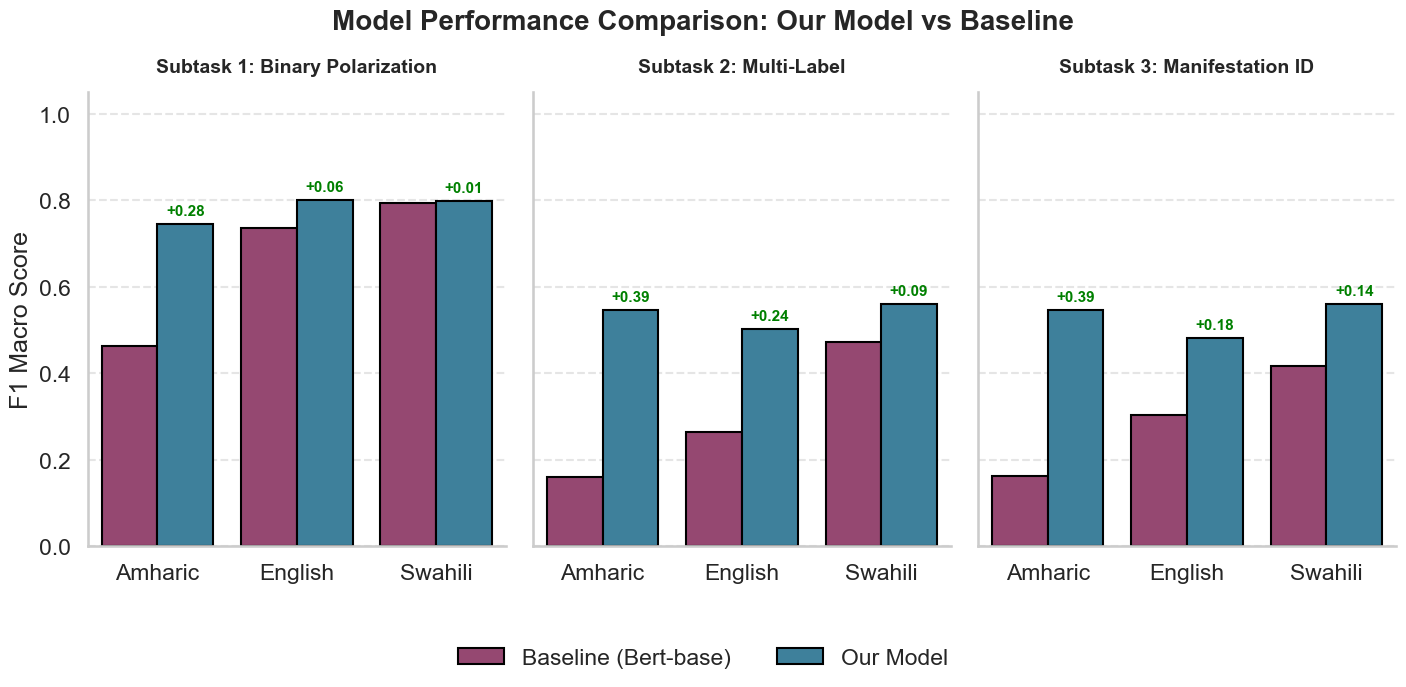

In [ ]:

sns.set_theme(style="whitegrid", context="talk")
OUTPUT_DIR = "results/figures"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def create_comparison_data():
    user_data = [
        (1, 'English', 0.8016, 'Our Model'),
        (1, 'Amharic', 0.7450, 'Our Model'),
        (1, 'Swahili', 0.7993, 'Our Model'),
        (2, 'English', 0.5026, 'Our Model'),
        (2, 'Amharic', 0.5475, 'Our Model'),
        (2, 'Swahili', 0.5612, 'Our Model'),

        (3, 'English', 0.4812, 'Our Model'),
        (3, 'Amharic', 0.5475, 'Our Model'), 
        (3, 'Swahili', 0.5612, 'Our Model'), 
    ]

    baseline_data = [
        (1, 'Amharic', 0.4642, 'Baseline (Bert-base)'),
        (1, 'English', 0.7373, 'Baseline (Bert-base)'),
        (1, 'Swahili', 0.7937, 'Baseline (Bert-base)'),
        (2, 'Amharic', 0.1596, 'Baseline (Bert-base)'),
        (2, 'English', 0.2642, 'Baseline (Bert-base)'),
        (2, 'Swahili', 0.4734, 'Baseline (Bert-base)'),
        (3, 'Amharic', 0.1614, 'Baseline (Bert-base)'),
        (3, 'English', 0.3046, 'Baseline (Bert-base)'),
        (3, 'Swahili', 0.4163, 'Baseline (Bert-base)'),
    ]

    all_data = user_data + baseline_data
    df = pd.DataFrame(all_data, columns=['Subtask', 'Language', 'Score', 'Model'])
    return df

def plot_comparison(df):
    lang_order = ['Amharic', 'English', 'Swahili']
    hue_order = ['Baseline (Bert-base)', 'Our Model']
    
    g = sns.catplot(
        data=df, 
        kind="bar",
        x="Language", 
        y="Score", 
        hue="Model",
        col="Subtask",
        order=lang_order,      
        hue_order=hue_order,   
        palette=["#A23B72", "#2E86AB"], 
        height=6, 
        aspect=0.8,
        edgecolor="black",
        legend_out=False
    )

    subtask_titles = {1: 'Binary Polarization', 2: 'Multi-Label', 3: 'Manifestation ID'}
    
    for i, ax in enumerate(g.axes.flat):
        current_subtask = g.col_names[i]
        ax.set_title(f"Subtask {current_subtask}: {subtask_titles.get(current_subtask, '')}", 
                    fontsize=14, fontweight='bold', pad=15)
        ax.set_ylim(0, 1.05)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        for j, lang in enumerate(lang_order):
            try:
                user_score = df[(df['Subtask']==current_subtask) & (df['Language']==lang) & (df['Model']=='Our Model')]['Score'].values[0]
                base_score = df[(df['Subtask']==current_subtask) & (df['Language']==lang) & (df['Model']=='Baseline (Bert-base)')]['Score'].values[0]
                
                diff = user_score - base_score
                
                if diff > 0:
                    ax.text(
                        x=j + 0.2, 
                        y=user_score + 0.02, 
                        s=f"+{diff:.2f}", 
                        color='green', 
                        ha='center', 
                        fontweight='bold', 
                        fontsize=11
                    )
            except IndexError:
                continue

    g.set_axis_labels("", "F1 Macro Score")
    g.fig.suptitle("Model Performance Comparison: Our Model vs Baseline", y=1.05, fontsize=20, fontweight='bold')
    sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.02), ncol=2, title=None, frameon=False)
    
    filename = f"{OUTPUT_DIR}/Model_Comparison_Chart.pdf"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"Comparison chart saved to: {filename}")

if __name__ == "__main__":
    df = create_comparison_data()
    plot_comparison(df)